# Machine Learning Project 
#### KMLSAL001 & MRXDAV015

## Introduction
#### Problem Statement
With the increase of technology in daily lives there is the ability to create an inclusive and more productive enviroment for all people. One such method is to allow interaction between those with restricted motor skills and technology used, allowing for more independance.

One such scenario where this can be implemented is something as simple as reading. Although methods exist to tackle this there is nothing stopping the improvemnt and implentation of newer fetures. This would not also be limited to those with disabilities, but also improve the lives of well-abled people, with some physical restriction stopping them to use their arms.

#### Aim
The Aim of this project would be to train a machine learning algorithm to recognise the difference between blinking, left winking or right winking. which may be further implented to trigger further actions in a use cases, which include (but not limited) to:

* An amputee/motor impaired person wanting to turn a page while reading.
* A musician having thier hands full in a concert needin to move to the next page in sheet music.
* Another input method that could be used in gaming scenarios.

### Methodology

#### Data
Data has been collected using social media where people were asked to submit a short video of them blinking, winking with their left eye and winking with their right eye. This video data was then processed to create pictures from the frames in the videos. Those pictures were then manually categorized into its respective folders.
The accumulated data was then split into test, training and validation data using the sklearn library.

#### Model
For the model it was decided that a classification learning task be implented. Thus a supervised learning algorithm will be used.

Numpy, Pytorch, Sklearn, PIL and Pyplot libraries will be used with Python as the coding laguage.

Since input data is of 2D images where each pixel generally represents a feature, which will be in excess of relavancy, it is decided that a convolutional neural network will be used.

For the activation function the Rectified Linear Unit (ReLU) is used. This was decided based on fimilairity, computation speed, implentation. There is also the possibility of live implementation thus speed would be a good considiration.

Cross-enthropy loss function will be used, as this is better for classification tasks, vs MSE which would be used for a regression task.

Adam optimisation will also be used, as it works well with the ReLU function because of the usage of gradient descent.

#### Training
To train the model, learning data was split into validation and training. The model was then fit using the training data. This was done using randomly chosen hyperparameters that were then updated with the optimiser with the paremeters of the loss function. This was repeated through the all training data (in batches). In addition this process was repeated a specified number of times (epochs). The model was then evaluated against the evaluation data, based on the results it was redone with different chosen hyperparameters (batch length, epoch). Thereafter, the best performing model (against validation data) was chosen and then trained further on using the full learning data set.

#### Testing
The model was then evaluted on randomly chosen test data, thus giving a more accurate estimate to the models performance. These reults were recorded and were used to determine parameters in the implentation phase. Once again the model was trained on the full dataset (excluding the manually chosen test data).

#### Implementation

A program was designed that takes in a video(24 fps) and then splits it up per frame into a collection of images, these images were used as input into the model.

The output labels (in the form of an array), with the indices corrisponding with the input data, were then processed to determine if there was a blink, left or right wink, or nothing.

This processing was done using the test results of the model and implemented by taking a cetrain number of consective labels (λ), and using this to display what event occoured. This result was then presented to the user as text(which may be changed when implented further). 

λ was chosen as to keep the probilibility of 6 consecultive events (250ms) being correctly predicted to be greater than 0.33. Based of false- positive and negative occurances of the model's predictions.
6 frames were chosen as it gives a good representation of the total time of an average blink/wink (https://www.ucl.ac.uk/news/2005/jul/blink-and-you-miss-it)

In [1]:
# imports
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import SubsetRandomSampler
from PIL import Image

## Loading the data
The collected data with its corresponding labels placed into numpy arrays

In [6]:
dataset_dir = Path.cwd() / "Data"

xdata=np.load("data.npy")
ydata=np.load("labels.npy")
print(xdata.shape)

(1587, 128, 128)


## Splitting the data into teaching and testing sets

In [7]:
x_teach, x_test, y_teach, y_test = train_test_split(xdata, ydata, test_size=0.1)

## Spliting the teaching data into training and validation sets

In [8]:
xtrain, xval, ytrain, yval = train_test_split(x_teach, y_teach, test_size=0.1)

## Data customisation


In [9]:
class WINK(Dataset):
    def __init__(self, data, targets, transform=None):
        ''' Encoding the data using LabelEncoder() then converting the numpy arrays into tensors '''
        self.data = data
        self.transform = transform
        self.enc = LabelEncoder()
        targets = self.enc.fit_transform(targets.reshape(-1,))
        self.targets = torch.LongTensor(targets)
        
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = int(index.item())
            
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index])
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

## Scaling the data
Here the data is scaled between 0 and 1. The scaler is then fit to the training data and all the datasets have been transformed accordingly. 

In [10]:
scaler = MinMaxScaler()
x_train_shape = xtrain.shape
x_val_shape = xval.shape
x_test_shape = x_test.shape

# fit scaler on training data, and transform it as well
xtrain = scaler.fit_transform(xtrain.reshape(-1, 1))
xtrain = xtrain.reshape(x_train_shape)

# only transform sets used for evaluation 
xval = scaler.transform(xval.reshape(-1, 1))
xval = xval.reshape(x_val_shape)

x_test = scaler.transform(x_test.reshape(-1, 1))
x_test = x_test.reshape(x_test_shape)

## Transforming to tensors to use Pytorch library and applying dataloaders.
The block below is responsible for feeding the data into the model

In [11]:
BATCH_SIZE=32

In [12]:
transform = transforms.Compose(
    [
     transforms.ToTensor()
    ])
train_dataset = WINK(xtrain, ytrain, transform=transform)
val_dataset = WINK(xval, yval, transform=transform)
test_dataset = WINK(x_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset)) 


## Defining the neural network

The original images have a shape of 128x128

##### 1st convolutional layer:
- 1 input channel
- 9x9 kernal size
- produces 6 convolutional maps that has a shape of 120x120

The feature maps are then pooled to produce 6 maps that has a shape of 60x60

##### 2nd convolutional layer:
- 6 input channels
- 5x5 kernal size
- produces 16 convolutional maps that has a shape of 56x56

The feature maps are pooled again to produce 16 maps that has a shape of 27x27

##### 3rd convolutional layer (2nd hidden layer):
- 16 input channels
- 8x8 kernal size
- produces 20 convolutional maps that has a shape of 20x20

##### 4th convolutional layer (input into neural network):
- 20 input channels
- It will pool again in the forward pass before fc1 which will result in producing 20 feature maps that have a shape of 10x10
- This will create 2000 input features to be fed into the neural network

All activation neurons use the ReLu activation function

##### 1st layer (input layer)
- 2000 input features that connect to 120 neurons

##### 2nd layer (1st hidden layer)
- 120 neurons that connect to 84 neurons

##### 3rd layer (2nd hidden layer)
- 84 neurons that connect to 40 neurons

##### 4th layer (output layer)
- 40 neurons that connect to the 4 output neurons

The 4 output neurons represent:
1. When a person is blinking
2. When a person is winking with their left eye
3. When a person is not blinking
4. When a person is winking with their right eye  

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # original image has a shape of 128x128
        self.conv1 = nn.Conv2d(1, 6, 9) # produces 6 120x120 maps
        self.pool = nn.MaxPool2d(2, 2) # produces 6 60x60 maps
        self.conv2 = nn.Conv2d(6, 16, 5) # produces 16 56x56 maps
        self.pool = nn.MaxPool2d(2, 2)  # produces 16 27x27 maps 
        self.conv3 = nn.Conv2d(16, 20, 8) # produces 20 20x20 maps
        # another pooling stage after the forward pass that produces 20 10x10 maps
        self.fc1 = nn.Linear(20 * 10 * 10, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 40)
        self.fc4 = nn.Linear(40,4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))#relu activation used
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [26]:
model=Net()
print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(9, 9), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 20, kernel_size=(8, 8), stride=(1, 1))
  (fc1): Linear(in_features=2000, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=40, bias=True)
  (fc4): Linear(in_features=40, out_features=4, bias=True)
)


## Defining the optimisation and evaluation functions


In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            running_loss += loss.item()
        
    # Return mean loss, accuracy
    return running_loss / len(loader), correct / total,correct

## Training the model
After every epoch, the model updates its parameters using stochastic grandient decent. The accuracy and loss metrics are also captured every epoch to guage the model's performance.

In [30]:
MAX_EPOCHS=20

In [31]:
trainhistory = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
}
running_loss = 0.0
total = 0.0


for epoch in range(MAX_EPOCHS):  # loop over the dataset multiple times
    for i, data in enumerate(train_loader, 0):
        model.train()
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # keep record of loss across mini-batches until logged
        running_loss += loss.item()
        
        # log results
        if i % 10 == 9:    # log every 10 mini-batches
            mean_loss = running_loss / 10 
            
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            train_acc = correct / labels.size(0)
            
            trainhistory['train_loss'].append(mean_loss)
            trainhistory['train_acc'].append(train_acc)
            
            
            running_loss = 0.0
            
            # evaluate on validation dataset
            mean_loss, val_acc,right = evaluate(model, val_loader)
            trainhistory['val_loss'].append(mean_loss)
            trainhistory['val_acc'].append(val_acc)
                  

## Plotting the performance of the model:

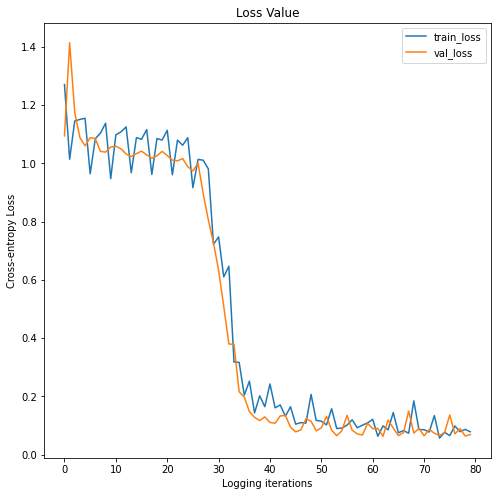

In [32]:
# Plotting the loss metrics during its training
fig = plt.figure(figsize=(8,8))
plt.plot(trainhistory['train_loss'], label='train_loss')
plt.plot(trainhistory['val_loss'], label='val_loss')
plt.xlabel("Logging iterations")
plt.ylabel("Cross-entropy Loss")
plt.title("Loss Value")
plt.legend()
plt.show()

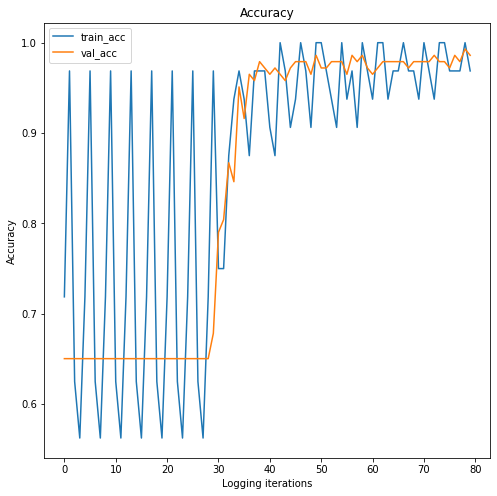

In [33]:
# Plotting its accuracy metrics during its training
fig = plt.figure(figsize=(8,8))
plt.plot(trainhistory['train_acc'], label='train_acc')
plt.plot(trainhistory['val_acc'], label='val_acc')
plt.xlabel("Logging iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

## Post evaluation training
Maybe put here what this block is doing

In [36]:
for i, data in enumerate(train_loader, 0):
    model.train()
    
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

for i, data in enumerate(val_loader, 0):
    model.train()

    # get the inputs; data is a list of [inputs, labels]
    inputs2, labels2 = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

## Testing the model

In [37]:
loss, acc, count = evaluate(model, test_loader)
print("loss: ",loss,"\nAcc: ",acc)

loss:  0.11368078738451004 
Acc:  0.9559748427672956


## Reporting on the results

#### Confusion Matrix:

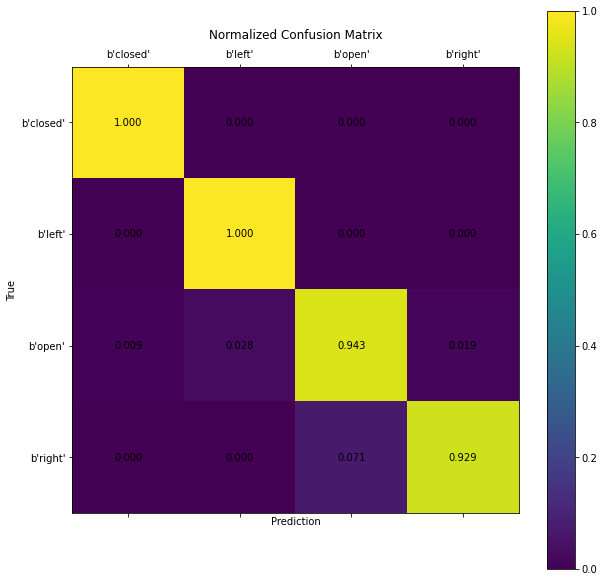

In [38]:
from sklearn.metrics import confusion_matrix
# In this case we know there will only be one batch consisting of the entire test set
it = iter(test_loader)
x, y = next(it)

outputs = model(x)
_, y_pred = torch.max(outputs, 1)

cm = confusion_matrix(y.numpy(), y_pred.numpy())
np.set_printoptions(precision=4)
plt.figure(figsize = (10,10))
cm = confusion_matrix(y.numpy(), y_pred.numpy(), normalize="true")
plt.matshow(cm, fignum=1)

for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')
    
plt.xticks(range(4))
plt.yticks(range(4))
plt.xlabel("Prediction")
plt.ylabel("True")

# We can retrieve the categories used by the LabelEncoder
classes = test_dataset.enc.classes_.tolist()
plt.gca().set_xticklabels(classes)
plt.gca().set_yticklabels(classes)

plt.title("Normalized Confusion Matrix")
plt.colorbar()
plt.show()

#### Displaying misclassified images: 

Here are some examples of when the model misclassified an image. It often occurs when the person is transitioning their eyes to wink or transistioning from winking to the normal state.

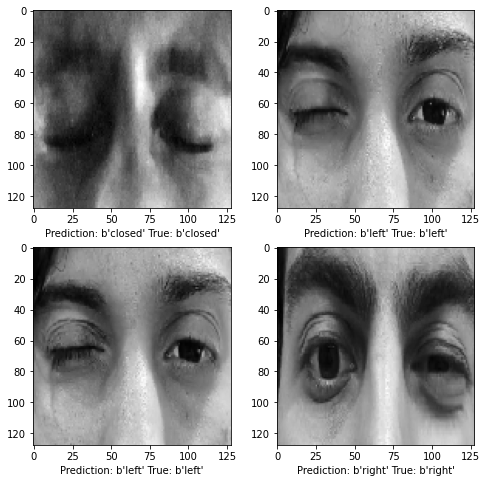

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()
# Get the indices for the cases where the predicted output was incorrect
false_idx = np.where(y.numpy() != y_pred.numpy())

for i, j in enumerate(false_idx[0][:4], 0):
    output = model(x[j].reshape(1, 1, 128, 128))
    _, y_pred = torch.max(output, 1)
    axes[i].imshow(x[j].reshape(128, 128), cmap='gray')
    axes[i].set_xlabel("Prediction: {} True: {}".format(classes[y_pred.item()], classes[y[j]]))


plt.show()

## Conclusion

<p> The model has successfully generalized to the data and is able to classify from images if a person is not-blinking, blinking, winking with their left eye or winking with their right eye. </p>

<p> For future implementation, we want to create a live video classifier. The idea would be to sample images by taking snap shots from the live video by using the front facing camera on a device and then feed that into this model. To mitigate the misclassification when the person transitions from winking to their normal state, we could implement a debouncing mechanism that when a blink/ wink is detected that the sampling will stop for a couple of milliseconds. </p> 

<p> Unfortunetly we did not implement this because of our limited knowledge on live video capturing and mostly due to the lack of time to work further on this project. </p>

